### Data Collection and Preprocessing

Work with the Caltech101 dataset. Preprocessing usually involves resizing the images to a consistent size and normalize the pixel values.

In [2]:
import tensorflow as tf
from keras import layers, models
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import itertools

In [2]:
(train_dataset, test_dataset), dataset_info = tfds.load(
    name='caltech101',
    split=['train', 'test'],
    with_info=True,
    as_supervised=True,
    data_dir='C:/Users/cesar/Downloads/tensorflow_datasets',
    download=False
)

In [28]:
name_classes = dataset_info.features['label'].names

In [4]:
def preprocess_image(image, label):
    image = tf.image.resize(image, (224, 224))
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

In [5]:
train_dataset = train_dataset.map(preprocess_image).shuffle(1000).batch(32)
test_dataset = test_dataset.map(preprocess_image).batch(32)

In [9]:
train_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

### Feature Extraction

Use a pre-trained CNN model (e.g., VGG16) to extract features from the images.

Remove the top layers to get the feature vectors.

In [10]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model

In [11]:
# Load the VGG16 model with pretrained weights from ImageNet, without the top classification layer
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Create a new model that outputs the feature maps
model = Model(inputs=base_model.input, outputs=base_model.layers[-1].output)

In [16]:
# Function to extract features
def extract_features(dataset):
    features = []
    labels = []
    imgs = []
    for images, lbls in dataset:
        imgs.append(images)
        feature_maps = model.predict(images)
        features.append(feature_maps)
        labels.append(lbls.numpy())
    return features, labels,imgs

In [17]:
# Extract features for train and test datasets
train_features, train_labels,train_img = extract_features(train_dataset)
test_features, test_labels,test_img = extract_features(test_dataset)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 

### Indexing

Use an in-memory index using NumPy. Other alternatives are more scalable solutions like FAISS or an approximate nearest neighbor search library.

In [19]:
# Flatten the feature maps to create feature vectors
train_features_flat = np.array([feature.flatten() for batch in train_features for feature in batch])
train_labels_flat = np.array([label for batch in train_labels for label in batch])
train_img_flat = np.array([img for batch in train_img for img in batch])
test_img_flat = np.array([img for batch in test_img for img in batch])

In [114]:
# Optionally, save the features and labels for later use
np.save('train_features.npy', train_features_flat)
np.save('train_labels.npy', train_labels_flat)
np.save('train_img.npy', train_img_flat)
np.save('test_img.npy', test_img_flat)

In [3]:
# Load the saved features and labels
train_features_flat = np.load('train_features.npy')
train_labels_flat = np.load('train_labels.npy')
train_img_flat = np.load('train_img.npy')
test_img_flat = np.load('test_img.npy')

In [32]:
# Example query: Retrieve the 5 nearest neighbors for a test image
from sklearn.neighbors import NearestNeighbors

In [33]:
# Fit the NearestNeighbors model
nn_model = NearestNeighbors(n_neighbors=5, algorithm='ball_tree').fit(train_features_flat)

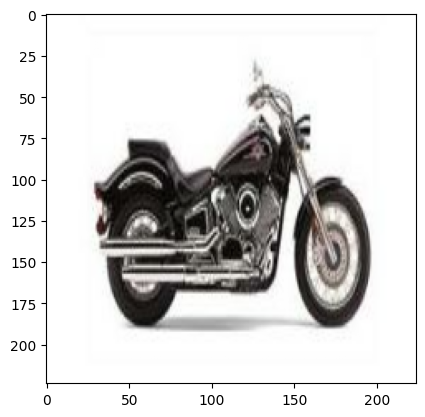

In [111]:
imagen_consulta =test_img_flat[2]
imagen_consulta = tf.expand_dims(imagen_consulta, axis=0)
plt.imshow(imagen_consulta[0])

In [112]:
query_features = model.predict([imagen_consulta]).flatten().reshape(1, -1)
# Find the nearest neighbors
distances, indices = nn_model.kneighbors(query_features)
print("Indices of nearest neighbors:", indices)
print("Distances to nearest neighbors:", distances)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
Indices of nearest neighbors: [[ 237 2260 1429 2214 2438]]
Distances to nearest neighbors: [[30.97731556 31.1232499  37.39177211 38.02494874 38.82652736]]


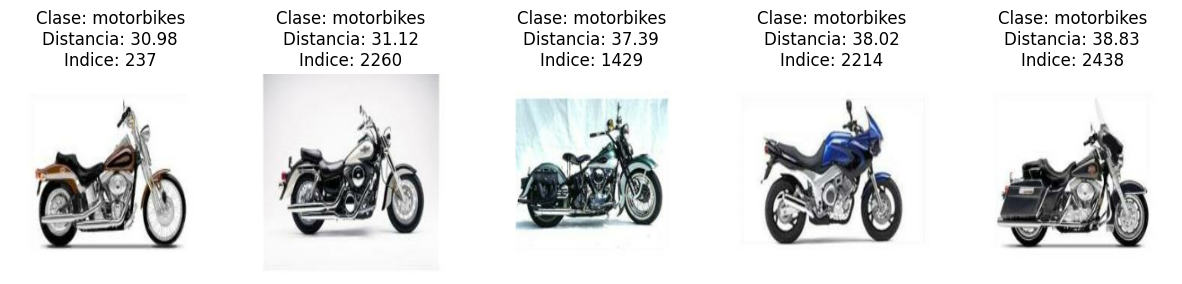

In [113]:
nearest_images =[]
nearest_labels = []
# Recuperar las imágenes de los vecinos más cercanos usando los índices
nearest_images = [train_img_flat[i] for i in indices.flatten()]
nearest_labels = [train_labels_flat[i] for i in indices.flatten()]
plt.figure(figsize=(15, 3))  # Ajustar el tamaño de la figura
for i, image in enumerate(nearest_images):
    plt.subplot(1, 5, i + 1)
    plt.imshow(image)
    plt.title("Clase: " + name_classes[nearest_labels[i]] + "\nDistancia: " + str(round(distances[0][i], 2))+ "\nIndice: " + str(indices[0][i]))
    plt.axis('off')
plt.show()